In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [26]:
# importa in an ealry version of the data
df_movie_plot = pd.read_csv(os.path.join('movie_plot_with_polarity.csv'))
df_movie_plot.head()

,title,title.1,budget,revenue,RB Ratio,RT Score,RB polarity,RT polarity,movie,plot
0,Avatar,Avatar,237000000,2787965087,11.763566,0.82,1,1,Avatar,A paraplegic Marine dispatched to the moon Pan...
1,Pirates of the Caribbean: At World's End,Pirates of the Caribbean: At World's End,300000000,961000000,3.203333,0.44,1,0,Pirates of the Caribbean: At World's End,"Captain Barbossa, Will Turner and Elizabeth Sw..."
2,Spectre,Spectre,245000000,880674609,3.594590,0.63,1,1,Spectre,A cryptic message from James Bond's past sends...
3,The Dark Knight Rises,The Dark Knight Rises,250000000,1084939099,4.339756,0.87,1,1,The Dark Knight Rises,Eight years after the Joker's reign of anarchy...
4,John Carter,John Carter,260000000,284139100,1.092843,0.52,0,0,John Carter,"Transported to Barsoom, a Civil War vet discov..."


In [3]:
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

### numpy for seed.  Good practice for reproducibility, not something we touched on but worth wild to look further.
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

In [4]:
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()
# this is to tolkenize the data

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(df_movie_plot['plot'].head().apply(lambda x : simple_tokenizer(x)))

### Developing the corpus or list of sentences for processing later
corpus = df_movie_plot['plot'].tolist()
corpus[0:5]

0    [a, paraplegic, marine, dispatched, to, the, m...
1    [captain, barbossa, will, turner, and, elizabe...
2    [a, cryptic, message, from, james, bonds, past...
3    [eight, years, after, the, jokers, reign, of, ...
4    [transported, to, barsoom, a, civil, war, vet,...
Name: plot, dtype: object


['A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes torn between following his orders and protecting the world he feels is his home.',
 'Captain Barbossa, Will Turner and Elizabeth Swann must sail off the edge of the map, navigate treachery and betrayal, find Jack Sparrow, and make their final alliances for one last decisive battle.',
 "A cryptic message from James Bond's past sends him on a trail to uncover the exsistence of a sinister organisation named SPECTRE. With a new threat dawning, Bond learns the terrible truth about the author of all his pain in his most recent missions.",
 "Eight years after the Joker's reign of anarchy, Batman, with the help of the enigmatic Catwoman, is forced from his exile to save Gotham City from the brutal guerrilla terrorist Bane.",
 'Transported to Barsoom, a Civil War vet discovers a barren planet seemingly inhabited by 12-foot tall barbarians. Finding himself prisoner of these creatures, he escapes, only to encounter W

In [14]:
# find polarity of critic score with plot
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus)
X = tf.transform(corpus)

### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), df_movie_plot['RB polarity']], axis=1)
print("Vector features : ", vectorizer.get_feature_names()[0:20])
print("Vector shape/size : ",X.shape)

Vector features :  ['', '00', '007', '10', '100000', '1000000', '11', '119', '11th', '11yearold', '12', '1206', '12foot', '12th', '13', '14', '1408', '142', '14yearold', '15']
Vector shape/size :  (2895, 10728)


In [15]:
target_col = 'RB polarity'
y=df_movie_plot[target_col]
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(target_col, axis=1)
                                                    ,y, test_size=0.20, random_state=SEED)
print(X_train.shape, y_train.shape)

(2316, 10728) (2316,)


In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [16]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [18]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 54.06 %


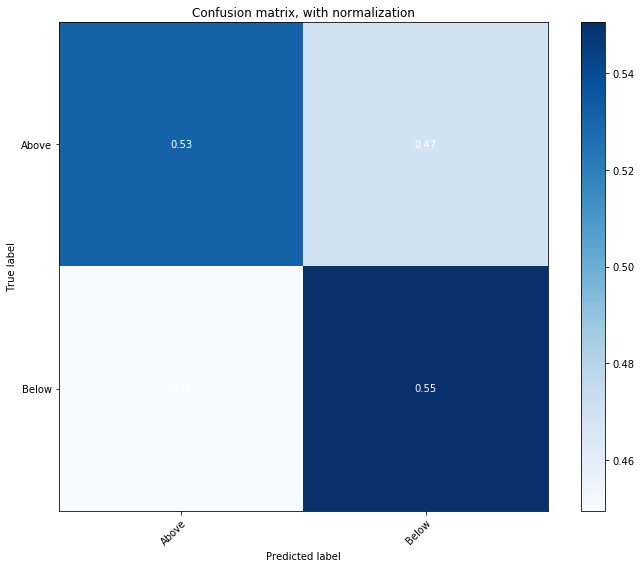

In [19]:
#this shows the possibility of false negatives for the data
class_names = ['Above', 'Below']
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

In [34]:
plot = 'the '
### Transform Review
review_transformed = tf.transform([plot])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("The profit will be {} the medium".format(class_names[pred[0]]))

The profit will be Below the medium
